# Compare loanword integration with standard corpus
We want to determine if the location-based patterns that we observe in the light verb prediction are part of a broader trend toward more light verb use in certain locations.

We therefore collect counts from a "standard" corpus of newspaper texts in Spanish-speaking countries, available [here](https://www.corpusdelespanol.org/now/).

With a bit of hacking, we can get these frequency counts automatically from the query page.

# Table of contents

1. Compare newspaper vs. social media integrated verb rates
    1. [Newspaper: Load, clean](#Compare-loanword-integration-with-newspaper-data)
    2. [Newspaper: compare across locations](#Newspaper-data:-compare-significance-of-differences)
    3. [Social media: Load, clean](#Compare-newspaper-vs.-social-media-data)
    4. [Newspaper + social media: compare aggregate](#Newspaper+social-media-data:-compare-aggregate-integrated-rates)
    5. [Newspaper + social media: compare regions](#Newspaper+social-media-data:-compare-per-region-integrated-rates)
    6. [Newspaper + social media: find word differences](#Newspaper+social-media-data:-Find-words-with-significant-differences-in-integration)

### Compare loanword integration with newspaper data
Many moons later...we have collected word counts from the newspaper corpus.

Let's test the rate of light verb use for Latin American countries.

In [1]:
# load newspaper data
import pandas as pd
from pattern.es import conjugate, INFINITIVE
newspaper_data_file = '../../data/newspaper_data/loanword_native_verb_newspaper_country_counts.csv'
newspaper_data = pd.read_csv(newspaper_data_file)
# add column for original verb form => easier matching!
def convert_to_verb_phrase(txt):
    txt_split = txt.split(' ')
    verb_phrase = ''
    if(len(txt_split) > 1):
        verb_phrase = ' '.join([conjugate(txt_split[0], INFINITIVE)]+txt_split[1:])
    else:
        verb_phrase = conjugate(txt, INFINITIVE)
    return verb_phrase
newspaper_data = newspaper_data.assign(**{
    'verb_phrase' : newspaper_data.loc[:, 'query'].apply(lambda x: convert_to_verb_phrase(x))
})
display(newspaper_data.head())
print(newspaper_data.shape[0])

,query,AR,BO,CL,CO,CR,CU,DO,EC,ES,...,NI,PA,PE,PR,PY,SV,US,UY,VE,verb_phrase
0,busca en google,13,0,16,18,4,8,4,1,91,...,5,5,16,3,0,3,26,4,10,buscar en google
1,buscáis en google,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,buscar en google
2,buscamos en google,12,4,4,4,2,2,2,0,46,...,0,0,4,0,0,2,20,2,6,buscar en google
3,buscan en google,9,1,4,9,0,42,3,2,19,...,0,0,15,0,1,0,7,1,4,buscar en google
4,buscar en google,67,12,46,64,8,14,15,14,228,...,8,8,62,4,5,9,50,8,33,buscar en google


3627


In [2]:
import re
loanword_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_integrated_verbs_light_verbs.tsv', sep='\t')
native_verb_data = pd.read_csv('../../data/loanword_resources/native_verb_light_verb_pairs.csv')
# flatten loanword light verb data
flat_loanword_data = []
for idx, data_i in loanword_data.iterrows():
    light_verb_i = data_i.loc['light_verb']
    light_verb_i_split = light_verb_i.split(' ')
    light_verb_i_verb = light_verb_i_split[0]
    light_verb_i_non_verb = ' '.join(light_verb_i_split[1:])
    for verb_j in light_verb_i_verb.split('|'):
        light_verb_phrase_j = ' '.join([verb_j, light_verb_i_non_verb])
        data_j = [data_i.loc['loanword'], data_i.loc['integrated_verb'], light_verb_phrase_j]
        flat_loanword_data.append(data_j)
loanword_data = pd.DataFrame(flat_loanword_data, columns=['loanword', 'integrated_verb', 'light_verb'])
# combine for easier data handling
loanword_data = loanword_data.assign(**{
    'word_type' : 'loanword'
})
loanword_data.rename(columns={'loanword' : 'word'}, inplace=True)
native_verb_data = native_verb_data.assign(**{
    'word_type' : 'native_verb',
    'word' : native_verb_data.loc[:, 'integrated_verb'],
})
word_data = pd.concat([loanword_data, native_verb_data], axis=0)
# clean up parentheses
paren_matcher = re.compile('[\(\)]')
word_data = word_data.assign(**{
    'light_verb' : word_data.loc[:, 'light_verb'].apply(lambda x: paren_matcher.sub('', x))
})
# reshape for better matching
word_data = pd.melt(word_data, 
                    id_vars=['word', 'word_type'], 
                    value_vars=['integrated_verb', 'light_verb'], 
                    var_name='verb_type', value_name='verb')
display(word_data.head())

,word,word_type,verb_type,verb
0,access,loanword,integrated_verb,accesar
1,access,loanword,integrated_verb,accesar
2,aim,loanword,integrated_verb,aimear
3,aim,loanword,integrated_verb,aimear
4,alert,loanword,integrated_verb,alertear


In [3]:
# match with loanword and native word data
newspaper_word_data = pd.merge(word_data, newspaper_data, left_on='verb', right_on='verb_phrase', how='right')
# drop duplicates?
newspaper_word_data.drop_duplicates('query', inplace=True)
# flatten to have one word/type/country/count tuple per line
import re
country_code_matcher = re.compile('[A-Z]{2}')
country_codes = list(sorted(filter(lambda x: country_code_matcher.match(x) is not None, newspaper_word_data.columns)))
newspaper_word_data = pd.melt(newspaper_word_data, value_vars=country_codes, var_name='country', value_name='count', id_vars=['word', 'word_type', 'verb_type', 'verb', 'query', 'verb_phrase'])
# add region for later
europe_country_codes = ['ES']
us_country_codes = ['PR']
latin_american_country_codes = list(filter(lambda x: x not in europe_country_codes and x not in us_country_codes, country_codes))
regions = ['europe', 'us_america', 'latin_america']
region_country_codes = [europe_country_codes, us_country_codes, latin_american_country_codes]
country_region_lookup = {}
for region, region_country_code_list in zip(regions, region_country_codes):
    country_region_lookup.update({c : region for c in region_country_code_list})
newspaper_word_data = newspaper_word_data.assign(**{
    'region' : newspaper_word_data.loc[:, 'country'].apply(country_region_lookup.get)
})

In [4]:
display(newspaper_word_data.head())

,word,word_type,verb_type,verb,query,verb_phrase,country,count,region
0,access,loanword,integrated_verb,accesar,accesáis,accesar,AR,0,latin_america
1,access,loanword,integrated_verb,accesar,accesamos,accesar,AR,0,latin_america
2,access,loanword,integrated_verb,accesar,accesan,accesar,AR,2,latin_america
3,access,loanword,integrated_verb,accesar,accesar,accesar,AR,28,latin_america
4,access,loanword,integrated_verb,accesar,accesará,accesar,AR,0,latin_america


OK! Let's compute the average rate of integration per country for the newspaper data.

In [5]:
# separate by word type
loanword_newspaper_word_data = newspaper_word_data[newspaper_word_data.loc[:, 'word_type']=='loanword']
native_verb_newspaper_word_data = newspaper_word_data[newspaper_word_data.loc[:, 'word_type']=='native_verb']
print(loanword_newspaper_word_data.shape[0])
print(native_verb_newspaper_word_data.shape[0])

42693
30639


In [6]:
# aggregate integration
from data_helpers import compute_integration_rate_all_words
word_var = 'word'
newspaper_loanword_integration_rate = loanword_newspaper_word_data.groupby(word_var).apply(lambda x: compute_integration_rate_all_words(x)).dropna(axis=1, inplace=False).reset_index(level=1,drop=True).reset_index().rename(columns={0:'integrated_rate'})
newspaper_native_verb_integration_rate = native_verb_newspaper_word_data.groupby(word_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index(level=1,drop=True).reset_index().rename(columns={0:'integrated_rate'})
display(newspaper_loanword_integration_rate.head())
display(newspaper_native_verb_integration_rate.head())
# per-country integration
country_var = 'country'
per_country_newspaper_loanword_integration_rate = loanword_newspaper_word_data.groupby(country_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
per_country_newspaper_native_verb_integration_rate = native_verb_newspaper_word_data.groupby(country_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
display(per_country_newspaper_loanword_integration_rate.head())
display(per_country_newspaper_native_verb_integration_rate.head())

,word,integrated_rate
0,DM,0.120000
1,access,0.999726
2,audit,1.000000
3,ban,0.999110
4,block,0.857143


,word,integrated_rate
0,admirar,0.995995
1,animar,0.998042
2,anotar,0.955752
3,aterrizar,0.989339
4,castigar,0.999856


,country,word,integrated_rate
0,AR,DM,0.000000
1,AR,access,1.000000
2,AR,audit,1.000000
3,AR,ban,1.000000
4,AR,boycott,0.978811


,country,word,integrated_rate
0,AR,admirar,0.992009
1,AR,animar,0.999630
2,AR,anotar,0.915592
3,AR,aterrizar,0.987473
4,AR,castigar,0.999952


### Newspaper data: compare integration across countries and regions

Let's plot these out and see the distributions.

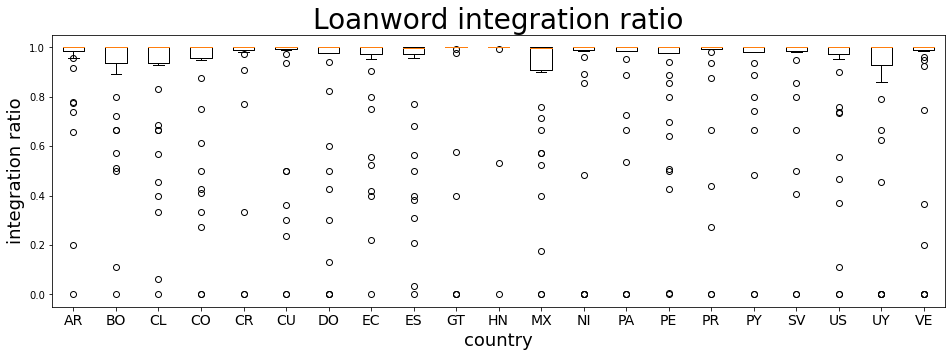

In [31]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
per_country_newspaper_loanword_integration_rate_vals = list(per_country_newspaper_loanword_integration_rate.groupby(country_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
plt.figure(figsize=(16,5))
X = np.arange(len(country_codes))+1
plt.boxplot(per_country_newspaper_loanword_integration_rate_vals)
plt.xticks(X, country_codes, fontsize=14)
plt.xlabel('country', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('Loanword integration ratio', fontsize=28)
plt.show()

OK! So far they all look identical, although `ES` has slightly lower variance than some of the other countries (`MX`, `BO`).

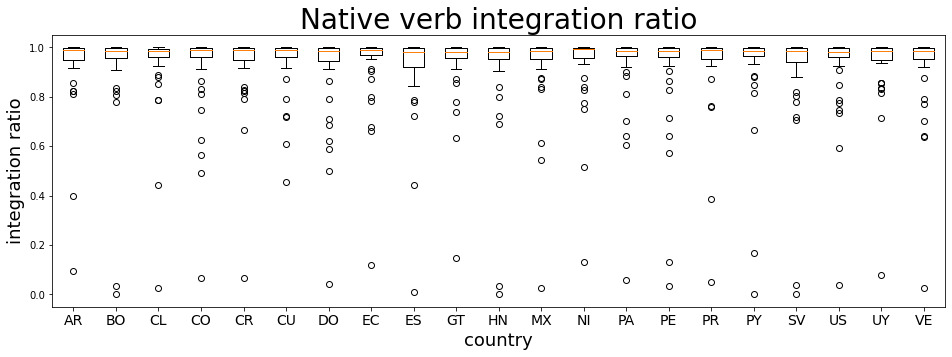

In [32]:
per_country_newspaper_native_verb_integration_rate_vals = list(per_country_newspaper_native_verb_integration_rate.groupby(country_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
plt.figure(figsize=(16,5))
X = np.arange(len(country_codes))+1
plt.boxplot(per_country_newspaper_native_verb_integration_rate_vals)
plt.xticks(X, country_codes, fontsize=14)
plt.xlabel('country', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('Native verb integration ratio', fontsize=28)
plt.show()

These rates seem much more regular. No surprise there.

Let's compare regions now.

In [13]:
# compute per-region newspaper integration: need this later!!
from data_helpers import compute_integration_rate_all_words
region_var = 'region'
per_region_newspaper_loanword_integration_rate = loanword_newspaper_word_data.groupby(region_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
per_region_newspaper_native_verb_integration_rate = native_verb_newspaper_word_data.groupby(region_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
region_codes = per_region_newspaper_loanword_integration_rate.loc[:, region_var].unique()

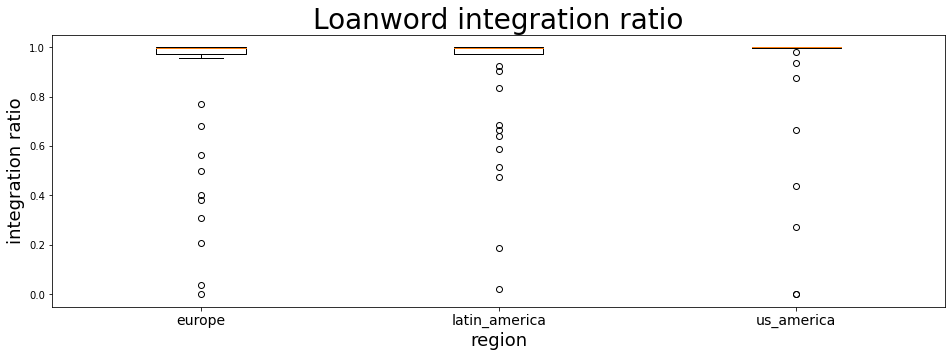

In [34]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
per_region_newspaper_loanword_integration_rate_vals = list(per_region_newspaper_loanword_integration_rate.groupby(region_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
# log-scsale
# smooth_val=1e-2
# per_region_newspaper_loanword_integration_rate_vals = list(per_region_newspaper_loanword_integration_rate.groupby(region_var).apply(lambda x: np.log(x.loc[:, 'integrated_rate'].values+smooth_val)))
plt.figure(figsize=(16,5))
X = np.arange(len(region_codes))+1
plt.boxplot(per_region_newspaper_loanword_integration_rate_vals)
plt.xticks(X, region_codes, fontsize=14)
plt.xlabel('region', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('Loanword integration ratio', fontsize=28)
plt.show()

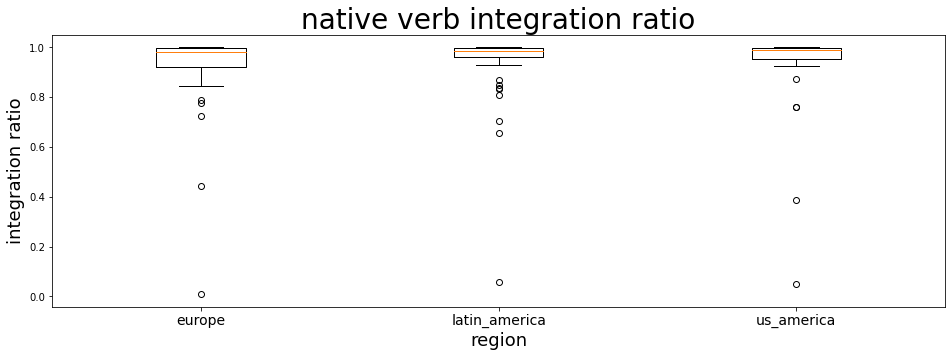

In [35]:
per_region_newspaper_native_verb_integration_rate_vals = list(per_region_newspaper_native_verb_integration_rate.groupby(region_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
plt.figure(figsize=(16,5))
X = np.arange(len(region_codes))+1
plt.boxplot(per_region_newspaper_native_verb_integration_rate_vals)
plt.xticks(X, region_codes, fontsize=14)
plt.xlabel('region', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('native verb integration ratio', fontsize=28)
plt.show()

Again, it's hard to tell the exact differences but it looks like most of the rates are close to 1 for loanwords and native verbs.

### Newspaper data: compare significance of differences
Do Latin American countries tend to use more integration than Europe, as suggested by the regression?

In [36]:
# unpaired test because lazy
from scipy.stats import mannwhitneyu
# loanwords 
print('testing loanwords')
latin_american_integration_rates = per_region_newspaper_loanword_integration_rate[per_region_newspaper_loanword_integration_rate.loc[:, 'region']=='latin_america'].loc[:, 'integrated_rate'].values
europe_integration_rates = per_region_newspaper_loanword_integration_rate[per_region_newspaper_loanword_integration_rate.loc[:, 'region']=='europe'].loc[:, 'integrated_rate'].values
test_stat, p_val = mannwhitneyu(latin_american_integration_rates, europe_integration_rates)
print('Latin America integration has median=%.3f'%(np.median(latin_american_integration_rates)))
print('Europe integration has median=%.3f'%(np.median(europe_integration_rates)))
print('difference has test stat=%.3f (p=%.3E)'%(test_stat, p_val))
# native verbs
print('testing native verbs')
latin_american_integration_rates = per_region_newspaper_native_verb_integration_rate[per_region_newspaper_native_verb_integration_rate.loc[:, 'region']=='latin_america'].loc[:, 'integrated_rate'].values
europe_integration_rates = per_region_newspaper_native_verb_integration_rate[per_region_newspaper_native_verb_integration_rate.loc[:, 'region']=='europe'].loc[:, 'integrated_rate'].values
test_stat, p_val = mannwhitneyu(latin_american_integration_rates, europe_integration_rates)
print('Latin America integration has median=%.3f'%(np.median(latin_american_integration_rates)))
print('Europe integration has median=%.3f'%(np.median(europe_integration_rates)))
print('difference has test stat=%.3f (p=%.3E)'%(test_stat, p_val))

testing loanwords
Latin America integration has median=0.998
Europe integration has median=0.998
difference has test stat=929.500 (p=2.468E-01)
testing native verbs
Latin America integration has median=0.985
Europe integration has median=0.980
difference has test stat=783.000 (p=4.369E-01)


In [37]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
def test_difference_by_category(data, category_var, category_1, category_2):
    word_var = 'word'
    dep_var = 'integrated_rate'
    data_1 = data[data.loc[:, category_var]==category_1].loc[:, [word_var, dep_var]]
    data_2 = data[data.loc[:, category_var]==category_2].loc[:, [word_var, dep_var]]
    data_combined = pd.merge(data_1, data_2, on=word_var)
    # drop nan vals
    data_combined.dropna(axis=1, how='any', inplace=True)
    data_vals_1 = data_combined.loc[:, f'{dep_var}_x']
    data_vals_2 = data_combined.loc[:, f'{dep_var}_y']
    median_diff = np.median(data_vals_1 - data_vals_2)
    test_stat, p_val = wilcoxon(data_vals_1, data_vals_2)
#     test_stat, p_val = ttest_rel(data_vals_1, data_vals_2)
    return median_diff, test_stat, p_val

In [38]:
# paired test because rigorous
latin_america_region = 'latin_america'
europe_region = 'europe'
median_diff, test_stat, p_val = test_difference_by_category(per_region_newspaper_loanword_integration_rate, region_var, latin_america_region, europe_region)
print(f'testing loanwords: {latin_america_region} vs. {europe_region}')
print('diff=%.3f; test stat = %.3f (p=%.3E)'%(median_diff, test_stat, p_val))
median_diff, test_stat, p_val = test_difference_by_category(per_region_newspaper_native_verb_integration_rate, region_var, latin_america_region, europe_region)
print(f'testing native verbs: {latin_america_region} vs. {europe_region}')
print('diff=%.3f; test stat = %.3f (p=%.3E)'%(median_diff, test_stat, p_val))

testing loanwords: latin_america vs. europe
diff=0.000; test stat = 244.000 (p=3.604E-01)
testing native verbs: latin_america vs. europe
diff=0.000; test stat = 318.000 (p=2.162E-01)


Great. For both paired and unpaired tests, we cannot conclude that Latin America has a different rate of integration than Europe.

How about at a per-country level?

In [41]:
# loanwords
country_var = 'country'
p_val_upper = 0.05 / (len(country_codes)*(len(country_codes)-1))
for i, country_code_i in enumerate(country_codes):
    for j, country_code_j in enumerate(country_codes[(i+1):]):
        median_diff, test_stat, p_val = test_difference_by_category(per_country_newspaper_loanword_integration_rate, country_var, country_code_i, country_code_j)
        print(f'testing {country_code_i} vs. {country_code_j}')
        if(p_val <= p_val_upper):
            print('SIGNIFICANT: diff=%.3f with test stat=%.3f (p=%.3E)'%(median_diff, test_stat, p_val))
        else:
            print('diff=%.3f with test stat=%.3f (p=%.3E)'%(median_diff, test_stat, p_val))

testing AR vs. BO
diff=0.000 with test stat=57.000 (p=4.202E-02)
testing AR vs. CL
diff=0.000 with test stat=75.000 (p=9.453E-02)
testing AR vs. CO
diff=0.000 with test stat=53.000 (p=2.983E-02)
testing AR vs. CR
diff=0.000 with test stat=85.000 (p=9.826E-01)
testing AR vs. CU
diff=0.000 with test stat=75.000 (p=4.209E-01)
testing AR vs. DO
diff=0.000 with test stat=67.000 (p=1.560E-01)
testing AR vs. EC
diff=0.000 with test stat=57.000 (p=1.262E-01)
testing AR vs. ES
diff=0.000 with test stat=73.000 (p=9.233E-03)
testing AR vs. GT
diff=0.000 with test stat=71.000 (p=7.946E-01)
testing AR vs. HN
diff=0.000 with test stat=25.000 (p=8.428E-02)
testing AR vs. MX
diff=0.000 with test stat=73.000 (p=1.603E-02)
testing AR vs. NI
diff=0.000 with test stat=74.000 (p=2.471E-01)
testing AR vs. PA
diff=0.000 with test stat=47.000 (p=1.626E-01)
testing AR vs. PE
diff=0.000 with test stat=84.000 (p=2.736E-01)
testing AR vs. PR
diff=0.000 with test stat=66.000 (p=2.432E-01)
testing AR vs. PY
diff=0.

After multiple hypothesis correction, none of these differences are significant.

### Compare newspaper vs. social media data
Let's compare the ratios from the newspaper data to the ratios from the social media data.

In [7]:
import pandas as pd
loanword_author_post_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t', usecols=['loanword', 'loanword_type', 'description_location_region'])
native_verb_author_post_data = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t', usecols=['native_word_category', 'native_word_type', 'description_location_region'])
loanword_author_post_data.fillna('', inplace=True)
native_verb_author_post_data.fillna('', inplace=True)
# cleanup
loanword_author_post_data.rename(columns={'loanword' : 'word', 'loanword_type' : 'verb_type', 'description_location_region':'region'}, inplace=True)
native_verb_author_post_data.rename(columns={'native_word_type' : 'word', 'native_word_category' : 'verb_type', 'description_location_region':'region'}, inplace=True)
loanword_author_post_data = loanword_author_post_data.assign(**{
    'verb_type' : loanword_author_post_data.loc[:, 'verb_type'].apply(lambda x: x.replace('integrated_loanword', 'integrated_verb').replace('light_verb_loanword', 'light_verb'))
})
native_verb_author_post_data = native_verb_author_post_data.assign(**{
    'verb_type' : native_verb_author_post_data.loc[:, 'verb_type'].apply(lambda x: x.replace('native_', ''))
})
# limit to valid data
post_location_var = 'region'
loanword_author_post_data = loanword_author_post_data[loanword_author_post_data.loc[:, post_location_var]!='']
native_verb_author_post_data = native_verb_author_post_data[native_verb_author_post_data.loc[:, post_location_var]!='']
display(loanword_author_post_data.head())
display(native_verb_author_post_data.head())
print(loanword_author_post_data.shape[0])
print(native_verb_author_post_data.shape[0])

,word,verb_type,region
0,audit,integrated_verb,latin_america
1,ban,integrated_verb,UNK
2,ban,integrated_verb,europe
3,flip,integrated_verb,europe
4,ban,integrated_verb,latin_america


,verb_type,word,region
0,integrated_verb,terminar,latin_america
1,integrated_verb,comprar,latin_america
2,integrated_verb,recomendar,latin_america
3,integrated_verb,preguntar,latin_america
4,integrated_verb,preguntar,latin_america


64479
247856


In [8]:
# def organize_compute_integration_ratio()
word_var = 'word'
word_type_var = 'verb_type'
loanword_post_counts = loanword_author_post_data.groupby([word_var, word_type_var, post_location_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0:'count'}, inplace=False)
native_verb_post_counts = native_verb_author_post_data.groupby([word_var, word_type_var, post_location_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0:'count'}, inplace=False)
display(loanword_post_counts.head())
display(native_verb_post_counts.head())

,word,verb_type,region,count
0,DM,light_verb,UNK,556
1,DM,light_verb,europe,56
2,DM,light_verb,latin_america,619
3,DM,light_verb,other,5
4,DM,light_verb,us_america,29


,word,verb_type,region,count
0,admirar,integrated_verb,UNK,383
1,admirar,integrated_verb,europe,24
2,admirar,integrated_verb,latin_america,293
3,admirar,integrated_verb,other,1
4,admirar,integrated_verb,us_america,16


In [9]:
# compute aggregate integration rates
from data_helpers import compute_integration_rate_all_words
word_var = 'word'
post_loanword_integration_rate = loanword_post_counts.groupby(word_var).apply(lambda x: compute_integration_rate_all_words(x)).dropna(axis=1, inplace=False).reset_index(level=1,drop=True).reset_index().rename(columns={0:'integrated_rate'})
post_native_verb_integration_rate = native_verb_post_counts.groupby(word_var).apply(lambda x: compute_integration_rate_all_words(x)).dropna(axis=1, inplace=False).reset_index(level=1,drop=True).reset_index().rename(columns={0:'integrated_rate'})
# compute per-region integration rates
region_var = 'region'
per_region_post_loanword_integration_rate = loanword_post_counts.groupby(region_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
per_region_post_native_verb_integration_rate = native_verb_post_counts.groupby(region_var).apply(lambda x: compute_integration_rate_all_words(x)).reset_index().rename(columns={0:'integrated_rate'})
region_codes = per_region_post_loanword_integration_rate.loc[:, region_var].unique()

In [10]:
display(per_region_post_loanword_integration_rate.head())
display(per_region_post_native_verb_integration_rate.head())

,region,word,integrated_rate
0,UNK,access,0.529412
1,UNK,aim,0.625000
2,UNK,audit,0.969466
3,UNK,ban,0.993750
4,UNK,block,0.113793


,region,word,integrated_rate
0,UNK,admirar,0.997396
1,UNK,amistar,0.181818
2,UNK,animar,0.945876
3,UNK,anotar,0.765416
4,UNK,aterrizar,0.987124


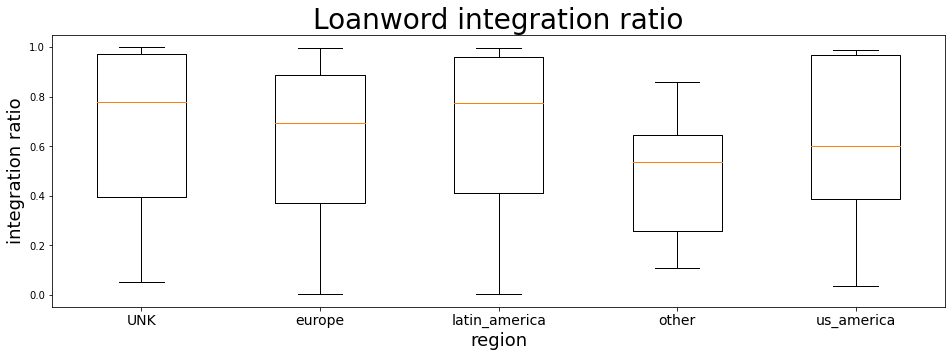

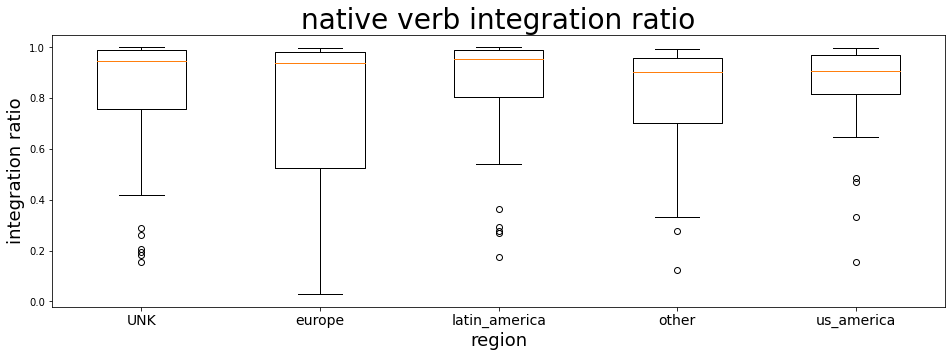

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
per_region_post_loanword_integration_rate_vals = list(per_region_post_loanword_integration_rate.groupby(region_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
# log-scsale
# smooth_val=1e-2
# per_region_loanword_integration_rate_vals = list(per_region_loanword_integration_rate.groupby(region_var).apply(lambda x: np.log(x.loc[:, 'integrated_rate'].values+smooth_val)))
plt.figure(figsize=(16,5))
X = np.arange(len(region_codes))+1
plt.boxplot(per_region_post_loanword_integration_rate_vals)
plt.xticks(X, region_codes, fontsize=14)
plt.xlabel('region', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('Loanword integration ratio', fontsize=28)
plt.show()
per_region_post_native_verb_integration_rate_vals = list(per_region_post_native_verb_integration_rate.groupby(region_var).apply(lambda x: x.loc[:, 'integrated_rate'].values))
plt.figure(figsize=(16,5))
X = np.arange(len(region_codes))+1
plt.boxplot(per_region_post_native_verb_integration_rate_vals)
plt.xticks(X, region_codes, fontsize=14)
plt.xlabel('region', fontsize=18)
plt.ylabel('integration ratio', fontsize=18)
plt.title('native verb integration ratio', fontsize=28)
plt.show()

OK! Right off the bat it looks like the social media data has lower integration rates than the newspaper data.

Can we verify this?

In [14]:
## combine data
## aggregate data
data_type_var = 'data_type'
word_type_var = 'word_type'
post_loanword_integration_rate = post_loanword_integration_rate.assign(**{
    data_type_var : 'social_media',
    word_type_var : 'loanword'
})
post_native_verb_integration_rate = post_native_verb_integration_rate.assign(**{
    data_type_var : 'social_media',
    word_type_var : 'native_verb'
})
newspaper_loanword_integration_rate = newspaper_loanword_integration_rate.assign(**{
    data_type_var : 'newspaper',
    word_type_var : 'loanword'
})
newspaper_native_verb_integration_rate = newspaper_native_verb_integration_rate.assign(**{
    data_type_var : 'newspaper',
    word_type_var : 'native_verb'
})
combined_integration_rate = pd.concat([
    post_loanword_integration_rate,
    post_native_verb_integration_rate,
    newspaper_loanword_integration_rate,
    newspaper_native_verb_integration_rate,
], axis=0)
## per-region data
per_region_post_loanword_integration_rate = per_region_post_loanword_integration_rate.assign(**{
    data_type_var : 'social_media',
    word_type_var : 'loanword'
})
per_region_post_native_verb_integration_rate = per_region_post_native_verb_integration_rate.assign(**{
    data_type_var : 'social_media',
    word_type_var : 'native_verb'
})
per_region_newspaper_loanword_integration_rate = per_region_newspaper_loanword_integration_rate.assign(**{
    data_type_var : 'newspaper',
    word_type_var : 'loanword'
})
per_region_newspaper_native_verb_integration_rate = per_region_newspaper_native_verb_integration_rate.assign(**{
    data_type_var : 'newspaper',
    word_type_var : 'native_verb'
})
combined_region_integration_rate = pd.concat([
    per_region_post_loanword_integration_rate,
    per_region_post_native_verb_integration_rate,
    per_region_newspaper_loanword_integration_rate,
    per_region_newspaper_native_verb_integration_rate,
], axis=0)
# add joint category
data_type_region_var = 'data_type+region'
combined_region_integration_rate = combined_region_integration_rate.assign(**{
    data_type_region_var : combined_region_integration_rate.loc[:, data_type_var] + '+' + combined_region_integration_rate.loc[:, region_var]
})
print(combined_region_integration_rate.loc[:, data_type_region_var].value_counts())

social_media+UNK              110
social_media+latin_america    109
newspaper+latin_america        85
newspaper+europe               85
newspaper+us_america           76
social_media+europe            70
social_media+us_america        44
social_media+other             28
Name: data_type+region, dtype: int64


### Newspaper+social media data: compare aggregate integrated rates

First let's compare the aggregate rate of integration across social media and newspaper.

In [19]:
# median tests
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import test_difference_by_category
import numpy as np
# get median integrated rate
# loanwords
social_media_data_type = 'social_media'
news_data_type = 'newspaper'
region_codes_valid = ['latin_america', 'europe', 'us_america']
word_types = ['loanword', 'native_verb']
word_type_var = 'word_type'
data_types = [social_media_data_type, news_data_type]
data_type_var = 'data_type'
dep_var = 'integrated_rate'
for word_type_i, data_i in combined_integration_rate.groupby(word_type_var):
    print(f'testing word type {word_type_i}')
    median_diff, test_stat, p_val = test_difference_by_category(data_i, data_type_var, social_media_data_type, news_data_type)
    for data_type_j in data_types:
        median_val_j = np.mean(data_i[data_i.loc[:, data_type_var]==data_type_j].loc[:, dep_var])
        print('data type %s has mean %.3f'%(data_type_j, median_val_j))
    print('median diff = %.3f, test stat = %.3f (p=%.3E)'%(median_diff, test_stat, p_val))

testing word type loanword
data type social_media has mean 0.678
data type newspaper has mean 0.891
median diff = -0.022, test stat = 14.000 (p=1.545E-07)
testing word type native_verb
data type social_media has mean 0.803
data type newspaper has mean 0.927
median diff = -0.014, test stat = 135.000 (p=1.090E-03)


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No handles with labels found to put in legend.


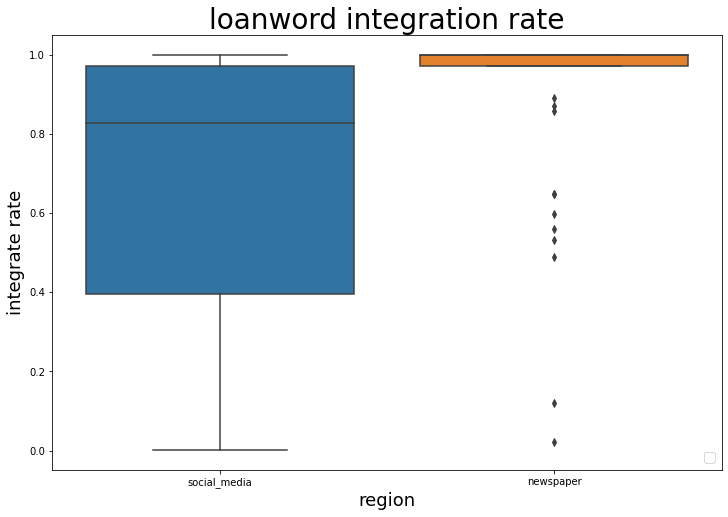

No handles with labels found to put in legend.


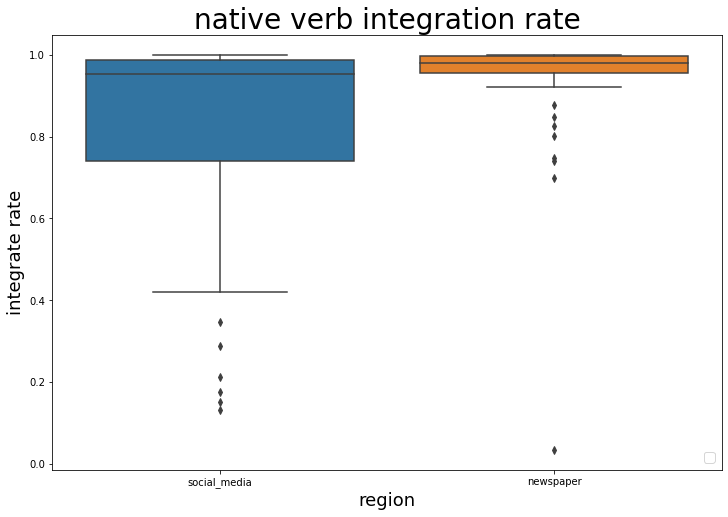

In [59]:
import seaborn as sns
data_type_var = 'data_type'
integrate_rate_var = 'integrated_rate'
word_type_var = 'word_type'
for word_type_i, data_i in combined_integration_rate.groupby(word_type_var):
    clean_word_type_i = word_type_i.replace('_', ' ')
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(x=data_type_var, y=integrate_rate_var, data=data_i)
    plt.legend(loc='lower right', fontsize=14)
    plt.ylabel('integrate rate', fontsize=18)
    plt.xlabel('region', fontsize=18)
    plt.title(f'{clean_word_type_i} integration rate', fontsize=28)
    plt.show()

OK! Social media overwhelmingly has lower integrated verb rates.

### Newspaper+social media data: compare per-region integrated rates

Next, we'll do it per region.

In [47]:
# loanwords
social_media_data_type = 'social_media'
news_data_type = 'newspaper'
region_codes_valid = ['latin_america', 'europe', 'us_america']
word_types = ['loanword', 'native_verb']
word_type_var = 'word_type'
for word_type_i, data_i in combined_region_integration_rate.groupby(word_type_var):
    print(f'testing word type {word_type_i}')
    for region_j in region_codes_valid:
        category_1 = f'{social_media_data_type}+{region_j}'
        category_2 = f'{news_data_type}+{region_j}'
        median_diff, test_stat, p_val = test_difference_by_category(data_i, data_type_region_var, category_1, category_2)
        print(f'testing region {region_j}')
        print('median diff = %.3f, test stat = %.3f (p=%.3E)'%(median_diff, test_stat, p_val))

testing word type loanword
testing region latin_america
median diff = -0.041, test stat = 28.000 (p=2.591E-06)
testing region europe
median diff = -0.273, test stat = 0.000 (p=5.957E-05)
testing region us_america
median diff = -0.297, test stat = 0.000 (p=3.346E-03)
testing word type native_verb
testing region latin_america
median diff = -0.009, test stat = 188.000 (p=2.272E-02)
testing region europe
median diff = -0.023, test stat = 89.000 (p=1.834E-03)
testing region us_america
median diff = -0.046, test stat = 25.000 (p=2.159E-04)


OK! Differences confirmed for almost all regions. Let's plot them side by side to make it clear.

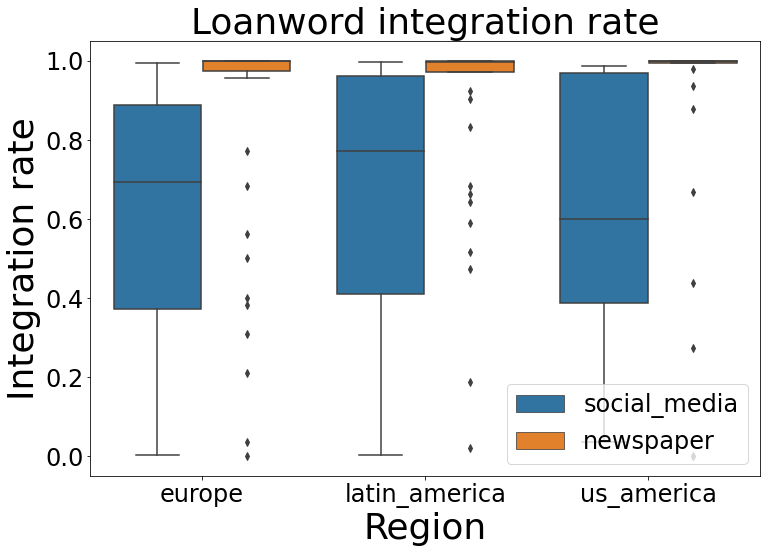

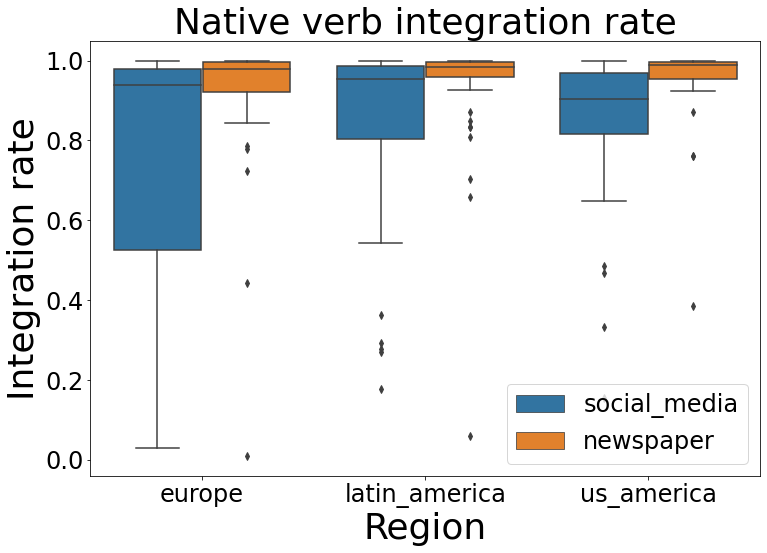

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
social_media_data_type = 'social_media'
news_data_type = 'newspaper'
integrate_rate_var = 'integrated_rate'
region_vals = ['europe', 'latin_america', 'us_america']
X = np.arange(len(region_vals))
region_var = 'region'
for word_type_i, data_i in combined_region_integration_rate.groupby(word_type_var):
    # restrict to valid regions
    data_i = data_i[data_i.loc[:, region_var].isin(region_vals)]
    clean_word_type_i = word_type_i.replace('_', ' ').capitalize()
    plt.figure(figsize=(12,8))
    sns.boxplot(x=region_var, y=integrate_rate_var, hue=data_type_var, data=data_i)
    plt.legend(loc='lower right', fontsize=24)
    plt.ylabel('Integration rate', fontsize=36)
    plt.xlabel('Region', fontsize=36)
    # fix tick size
    x_ticks, x_tick_labels = plt.xticks()
    y_ticks, y_tick_labels = plt.yticks()
    plt.xticks(x_ticks, x_tick_labels, fontsize=24)
    plt.yticks(y_ticks[1:-1], fontsize=24)
    plt.title(f'{clean_word_type_i} integration rate', fontsize=36)
    plt.show()

### Newspaper+social media data: Find words with significant differences in integration
Which words tend to be integrated much less often in social media as compared to newspaper writing?

Hypothesis: words that are more technical will see higher integration rates because newspapers are encouraged to standardize their use of technology terms.

In [75]:
word_var = 'word'
data_type_var = 'data_type'
word_type_var = 'word_type'
integrated_rate_var = 'integrated_rate'
top_k = 10
for word_type_i, data_i in combined_integration_rate.groupby(word_type_var):
    print(f'testing data {word_type_i}')
    social_media_data_i = data_i[data_i.loc[:, data_type_var]=='social_media'].loc[:, [word_var, integrated_rate_var]].rename(columns={integrated_rate_var:'integrated_rate_social'})
    newspaper_data_i = data_i[data_i.loc[:, data_type_var]=='newspaper'].loc[:, [word_var, integrated_rate_var]].rename(columns={integrated_rate_var:'integrated_rate_newspaper'})
    combined_data_i = pd.merge(social_media_data_i, newspaper_data_i, on='word')
    combined_data_i = combined_data_i.assign(**{
        'integrated_rate_diff' : combined_data_i.loc[:, 'integrated_rate_social'] - combined_data_i.loc[:, 'integrated_rate_newspaper']
    })
    print('%d word overlap'%(combined_data_i.shape[0]))
    print('words with highest integrated rate diff')
    combined_data_i.sort_values('integrated_rate_diff', ascending=False, inplace=True)
    display(combined_data_i.head(top_k))
    print('words with lowest integrated rate diff')
    combined_data_i.sort_values('integrated_rate_diff', ascending=True, inplace=True)
    display(combined_data_i.head(top_k))

testing data loanword
39 word overlap
words with highest integrated rate diff


,word,integrated_rate_social,integrated_rate_newspaper,integrated_rate_diff
22,pitch,0.996983,0.987573,0.009410
10,flip,0.999610,0.998868,0.000742
25,push,0.999617,0.999139,0.000478
14,host,0.971154,0.972222,-0.001068
13,hack,0.998604,1.000000,-0.001396
20,park,0.995215,0.999884,-0.004669
33,sniff,0.991935,0.998462,-0.006526
36,tick,0.992574,1.000000,-0.007426
17,knock,0.992424,0.999883,-0.007458
26,rank,0.991870,1.000000,-0.008130


words with lowest integrated rate diff


,word,integrated_rate_social,integrated_rate_newspaper,integrated_rate_diff
3,block,0.104762,0.857143,-0.752381
15,hype,0.267101,0.995327,-0.728226
19,link,0.227074,0.871716,-0.644641
18,like,0.051248,0.648780,-0.597533
21,perform,0.065089,0.561086,-0.495997
0,access,0.522581,0.999726,-0.477146
37,tweet,0.128505,0.598240,-0.469735
4,boycott,0.593000,0.989092,-0.396092
8,fangirl,0.631518,1.000000,-0.368482
23,post,0.676101,0.998908,-0.322807


testing data native_verb
37 word overlap
words with highest integrated rate diff


,word,integrated_rate_social,integrated_rate_newspaper,integrated_rate_diff
35,vistar,0.175337,0.034217,0.141120
24,prever,0.926829,0.800461,0.126368
28,respirar,0.992640,0.969872,0.022768
33,usar,0.988647,0.973328,0.015320
20,participar,0.998327,0.986497,0.011829
36,volar,0.997705,0.991533,0.006171
25,probar,0.987024,0.981289,0.005735
15,mencionar,0.972242,0.970387,0.001855
32,terminar,0.999843,0.998506,0.001337
16,mirar,0.999272,0.998483,0.000789


words with lowest integrated rate diff


,word,integrated_rate_social,integrated_rate_newspaper,integrated_rate_diff
10,ejemplificar,0.213836,0.748362,-0.534525
14,fotografiar,0.288591,0.741090,-0.452500
7,dañar,0.505952,0.921345,-0.415393
30,sestear,0.421053,0.698925,-0.277872
6,culpar,0.735196,0.970333,-0.235138
18,negociar,0.743367,0.970422,-0.227055
2,anotar,0.748774,0.955752,-0.206979
27,remediar,0.798165,0.976056,-0.177891
9,dudar,0.817760,0.974356,-0.156596
13,finalizar,0.700667,0.825655,-0.124988


In [69]:
social_media_data_i.head()

,word,integrated_rate,data_type,word_type
0,admirar,0.994452,social_media,native_verb
1,amistar,0.133333,social_media,native_verb
2,animar,0.943968,social_media,native_verb
3,anotar,0.748774,social_media,native_verb
4,aterrizar,0.985866,social_media,native_verb
